## Headers

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/AN2DL - Uomini Forti # change path if needed

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/.shortcut-targets-by-id/1D5VL5RTaxvKx3Upt1THeEjQn-M7YwfM7/AN2DL - Uomini Forti


In [2]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print("Tensorflow version:")
#!pip install --upgrade tensorflow
print(tf.__version__)

# Import other libraries
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

Tensorflow version:
2.14.0


## Import Data


In [3]:
def setup(filename, unzip = False): # set unzip = False once finished

  dataset = np.load('public_data.npz', allow_pickle=True)
  data = dataset['data']
  #labels = dataset['labels']
  labels = np.expand_dims(dataset['labels'], axis=-1)

  # Normalize the image pixel values to a float range
  for img in range(data.shape[0]):
    data[img] = (data[img] / 255).astype(np.float32)

  print("Original size of data:", data.shape)
  print("Original size of labels:", labels.shape)

  return data, labels


data, labels = setup('public_data')

Original size of data: (5200, 96, 96, 3)
Original size of labels: (5200, 1)


## Useful functions

In [4]:
# Convert labels to binary encoding
def binary_labels(labels):

    binary_labels = np.where(labels == "unhealthy", 1, 0)
    return binary_labels

def remove_matching_images(data, labels, image1, image2):

    cleaned_data = []
    cleaned_labels = []

    for img, label in zip(data, labels):
        if not np.array_equal(img, image1) and not np.array_equal(img, image2):
            cleaned_data.append(img)
            cleaned_labels.append(label)

    return np.array(cleaned_data), np.array(cleaned_labels)

def remove_duplicate_images(data, labels):

    unique_data = []
    unique_labels = []

    # Create a set to store unique representations of images
    unique_image_set = set()

    for img, label in zip(data, labels):
        img_representation = img.tostring()  # Convert the image to a string representation

        # Check if this representation is already in the set
        if img_representation not in unique_image_set:
            unique_image_set.add(img_representation)
            unique_data.append(img)
            unique_labels.append(label)

    return np.array(unique_data), np.array(unique_labels)

import tensorflow_probability as tfp

def mixup(images, labels, alpha=1, threshold=0.5, seed=seed):
    tf.random.set_seed(seed)

    batch_size = tf.shape(images)[0]
    beta = tfp.distributions.Beta(alpha, alpha).sample([batch_size])

    # Randomly shuffle indices
    indices = tf.range(batch_size)
    shuffled_indices = tf.random.shuffle(indices)

    # Mix up images and labels
    mixed_images = images * beta[:, tf.newaxis, tf.newaxis, tf.newaxis] + images[shuffled_indices] * (1 - beta[:, tf.newaxis, tf.newaxis, tf.newaxis])
    mixed_labels = labels * beta[:, tf.newaxis] + labels[shuffled_indices] * (1 - beta[:, tf.newaxis])

    # Apply threshold to the mixed labels
    mixed_labels = tf.where(mixed_labels > threshold, 1.0, 0.0)

    return mixed_images, mixed_labels

## Data cleaning

In [5]:
# Outliers
trololo = data[1757] # just an instance
shrek = data[2779] # just an instance

print("Removing outliers...")
cleaned_data, cleaned_labels = remove_matching_images(data, labels, trololo, shrek)
print("Data shape:", cleaned_data.shape)
print("Labels shape:", cleaned_labels.shape)

print("\nRemoving duplicates...")
cleaned_data, cleaned_labels = remove_duplicate_images(cleaned_data, cleaned_labels)
X = cleaned_data
y = binary_labels(cleaned_labels)
print("Data shape:", X.shape)
print("Labels shape:", y.shape)

Removing outliers...
Data shape: (5004, 96, 96, 3)
Labels shape: (5004, 1)

Removing duplicates...
Data shape: (4850, 96, 96, 3)
Labels shape: (4850, 1)


## Data slplitting

In [6]:
# Split data into train_val and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=seed, test_size=0.1, stratify=y)

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (4365, 96, 96, 3), y_train shape: (4365, 1)
X_val shape: (485, 96, 96, 3), y_val shape: (485, 1)


## Data exploration

[419 475 181 447 406 148 381 338 480 228   9 175 479 324 211 428  84  30
 462  90]


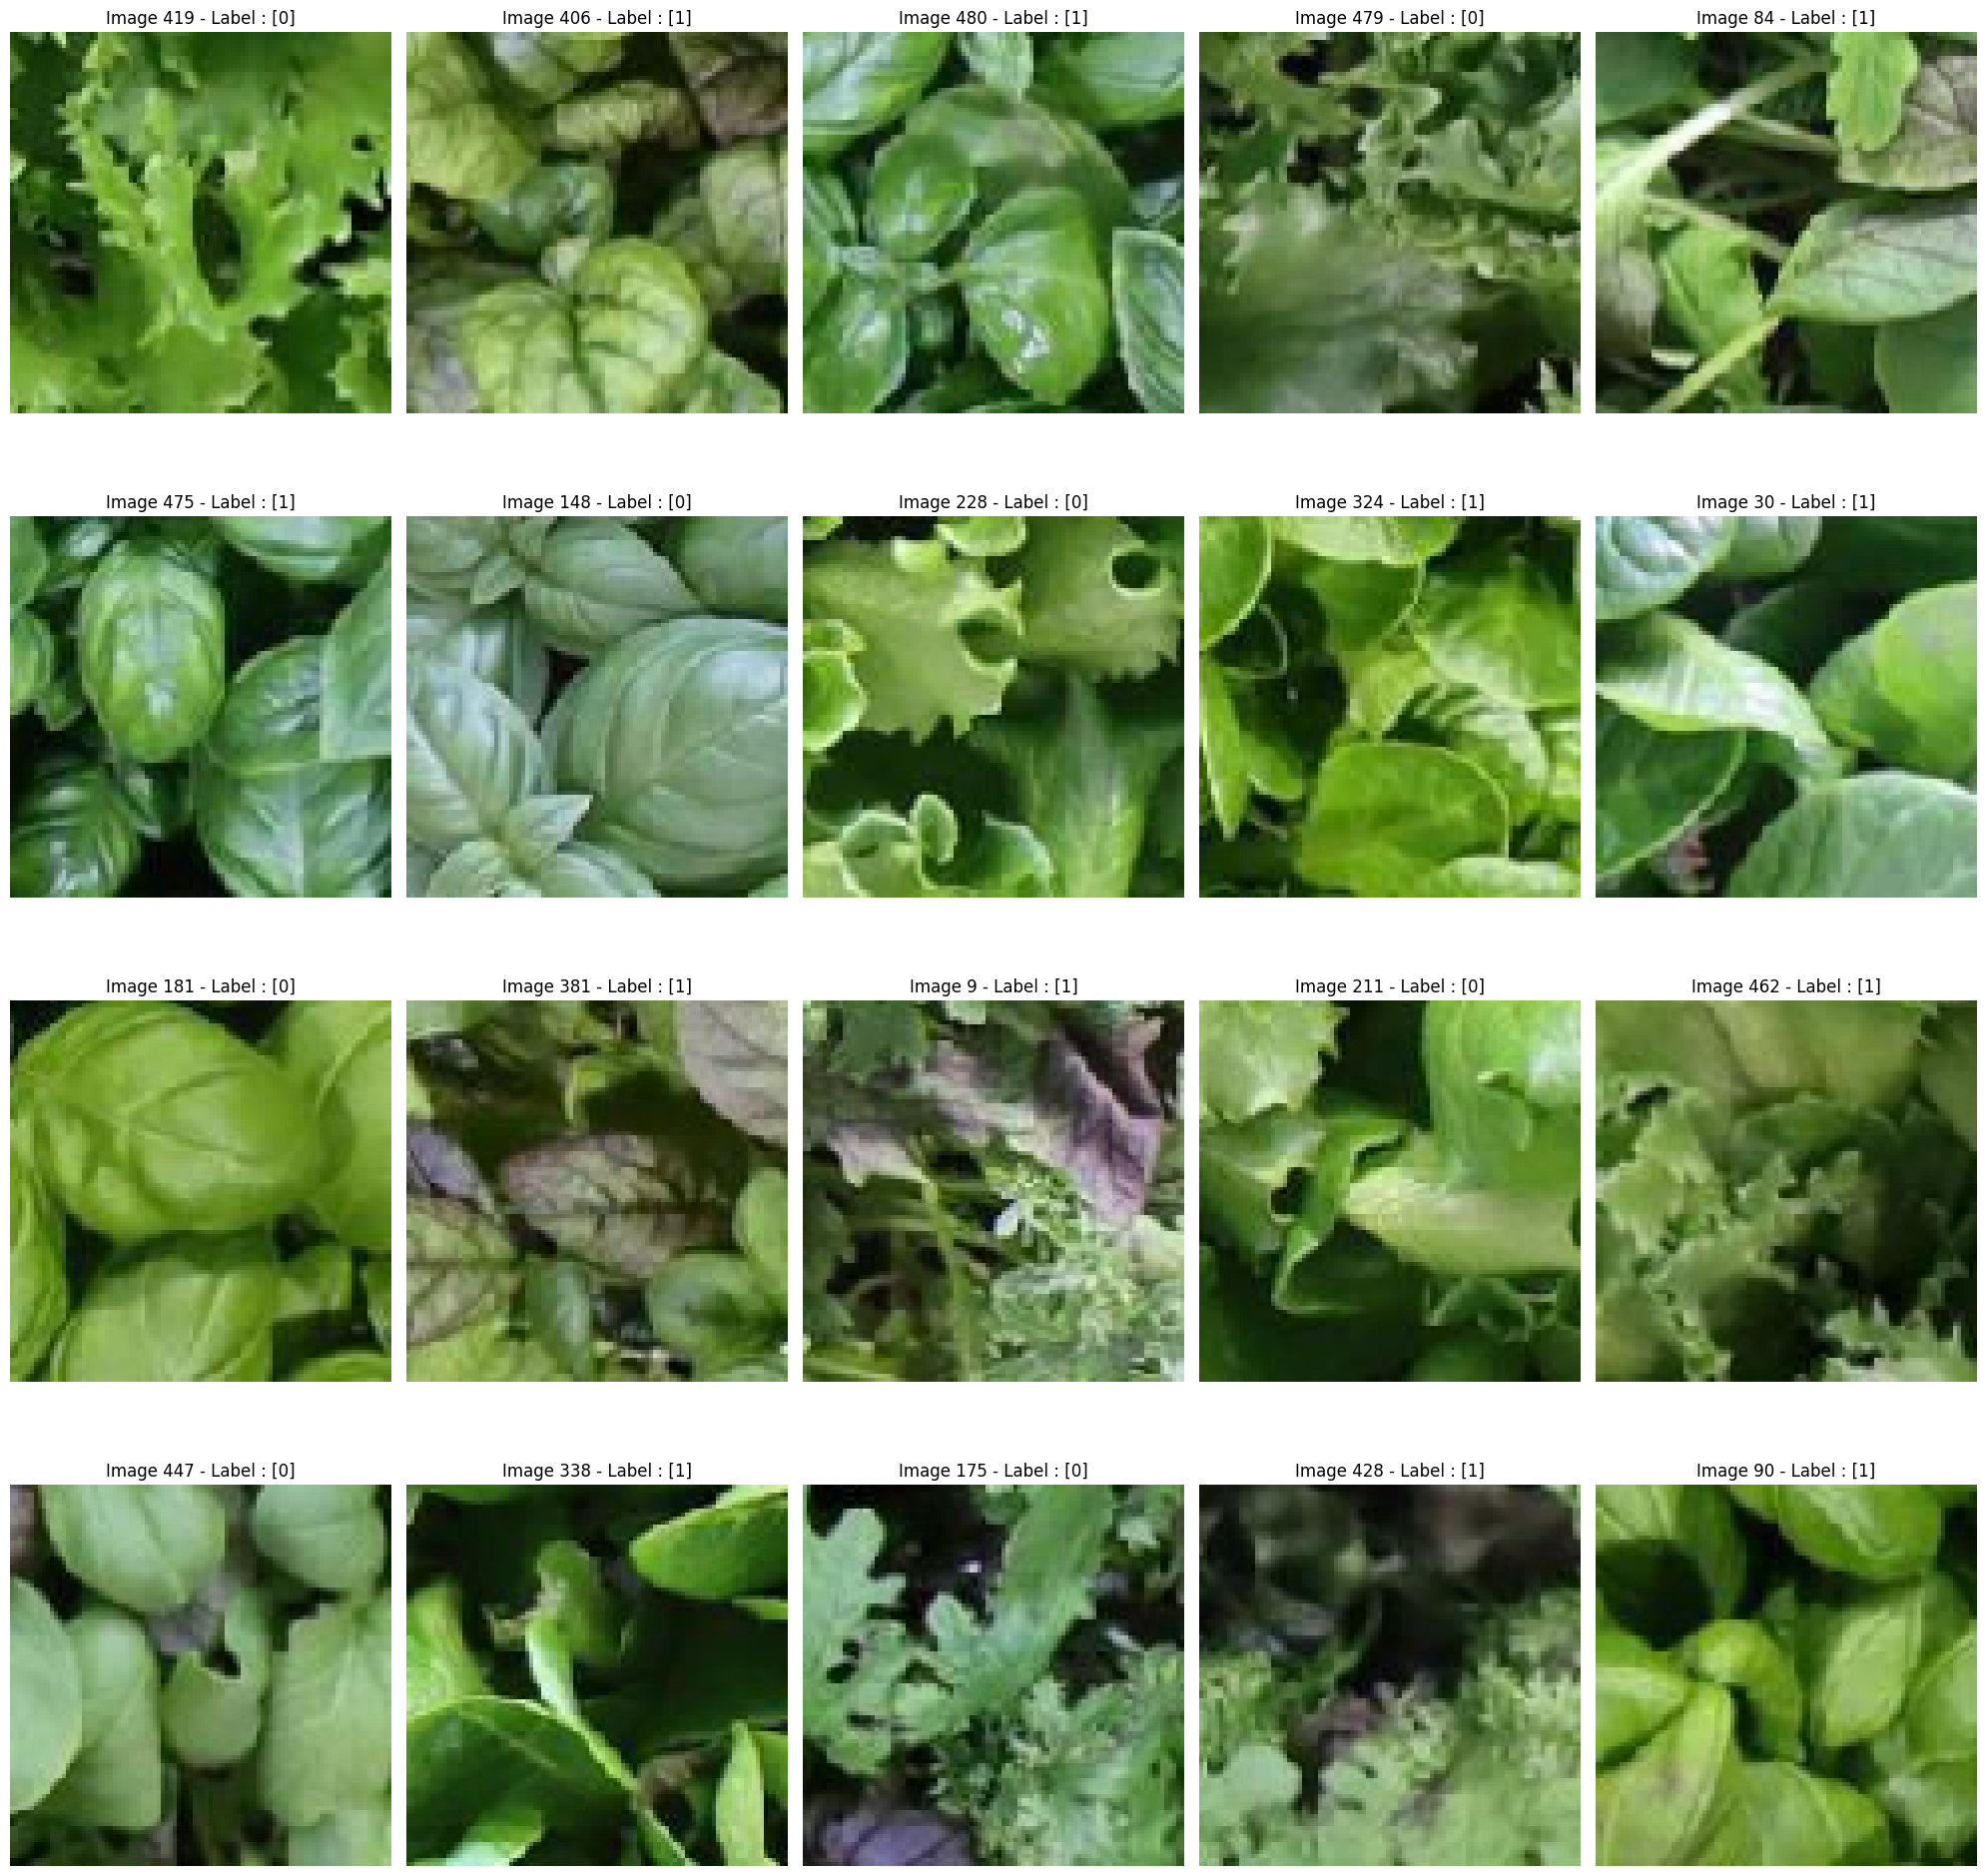

In [7]:
# Exploring validation data
num_img = 20
random_offset = np.random.choice(y_val.shape[0], num_img, replace=False)
print(random_offset)

fig, axes = plt.subplots(4, num_img//4, figsize=(20, 20))
for i in range(num_img):
    ax = axes[i%4, i%num_img//4]
    ax.imshow(np.clip(X_val[random_offset[i]], 0, 255))
    ax.set_title(f'Image {random_offset[i]} - Label : {y_val[random_offset[i]]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

[3239  354 4213 3182 3487  227 1101 1258  896 2612 1803 3933  296 1945
  199 2297 1503 2613   33  537]


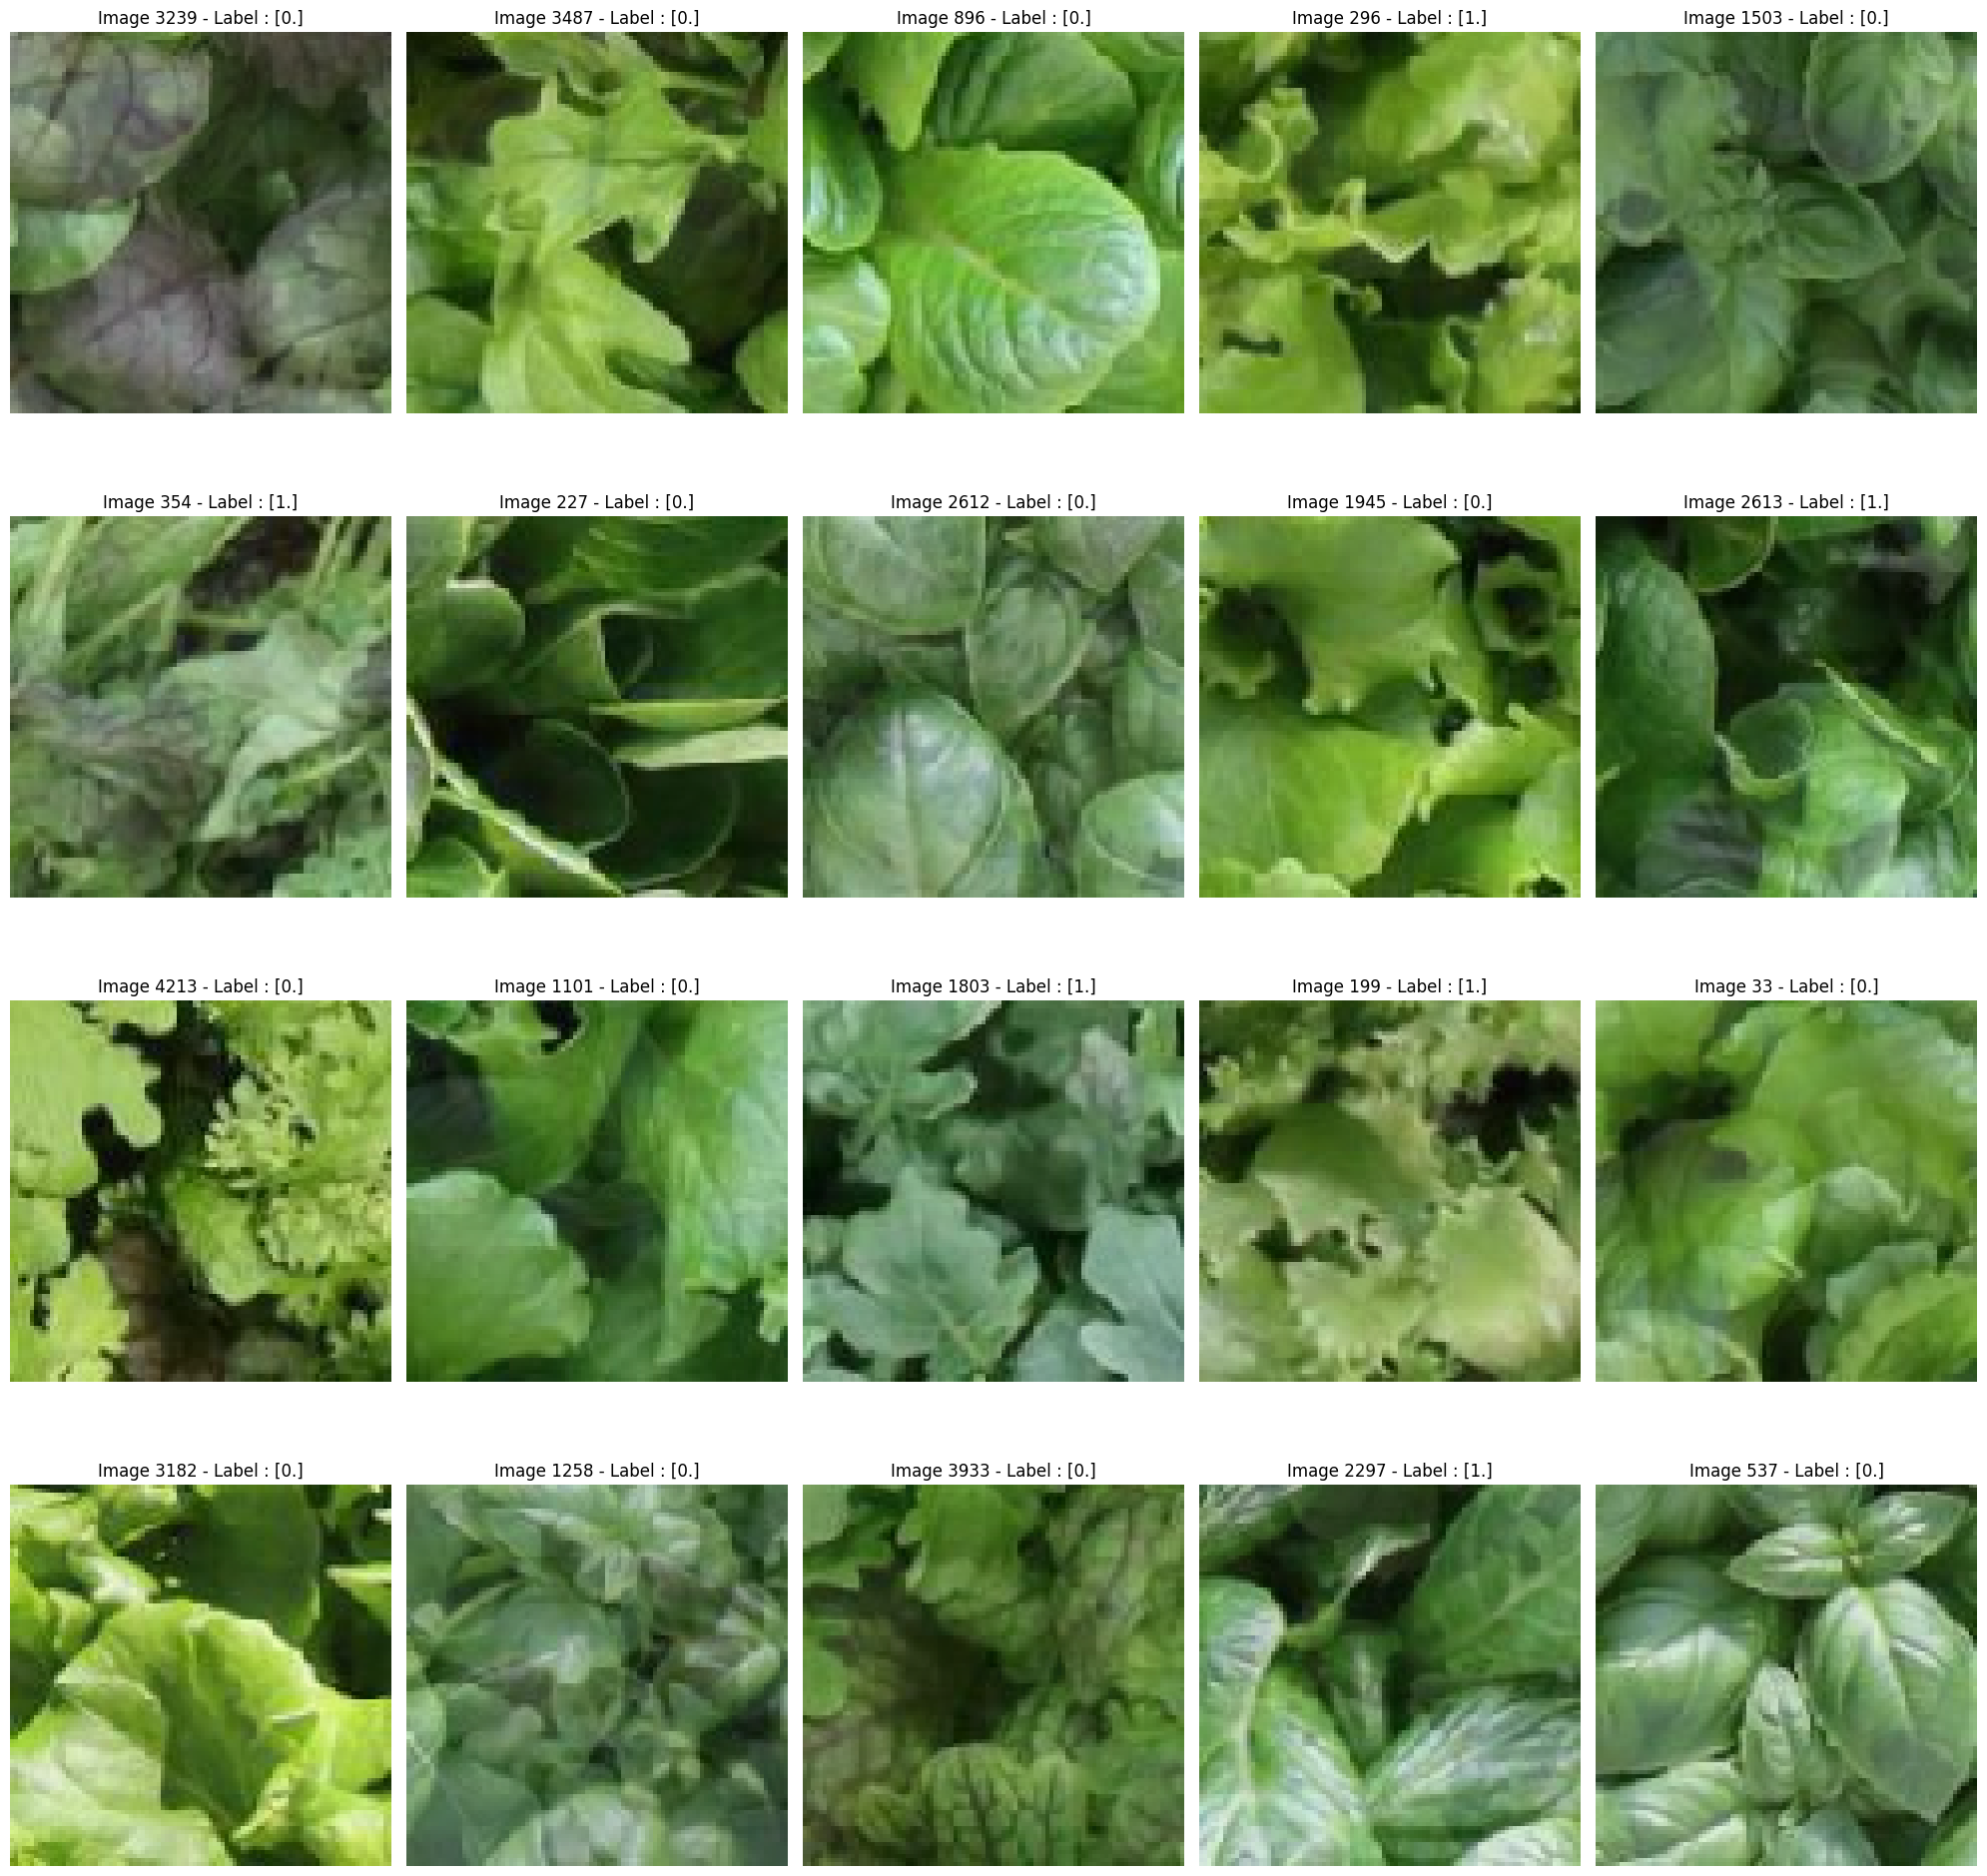

In [8]:
# Exploring mixup data
X_mix, y_mix = mixup(X_train, y_train)

num_img = 20
random_offset = np.random.choice(y_mix.shape[0], num_img, replace=False)
print(random_offset)

fig, axes = plt.subplots(4, num_img//4, figsize=(20, 20))
for i in range(num_img):
    ax = axes[i%4, i%num_img//4]
    ax.imshow(np.clip(X_mix[random_offset[i]], 0, 255))
    ax.set_title(f'Image {random_offset[i]} - Label : {y_mix[random_offset[i]]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [9]:
mix = True

def mixit(X, y, mix): # function for stacking NON-mixup with mixup data
  if mix == True:
    X_mix, y_mix = mixup(X, y)

    X_out = tf.convert_to_tensor(X, dtype=tf.float32)
    X_out = tf.concat([X, X_mix], axis=0)

    y_out = tf.convert_to_tensor(y, dtype=tf.float32)
    y_out = tf.concat([y, y_mix], axis=0)

    return X_out, y_out

  else:
    return X, y

X_train, y_train = mixit(X_train, y_train, mix)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_train type: {type(X_train)}; y_train shape: {type(y_train)}")
print(f"X_val shape: {X_train.shape}, y_val shape: {y_train.shape}")
print(f"X_val type: {type(X_val)}; y_val shape: {type(y_val)}")

X_train shape: (8730, 96, 96, 3), y_train shape: (8730, 1)
X_train type: <class 'tensorflow.python.framework.ops.EagerTensor'>; y_train shape: <class 'tensorflow.python.framework.ops.EagerTensor'>
X_val shape: (8730, 96, 96, 3), y_val shape: (8730, 1)
X_val type: <class 'numpy.ndarray'>; y_val shape: <class 'numpy.ndarray'>


[4997 6990 5642  624 2292  168 1086  978 2023 4397 5219 7038  410 3891
 1844 7809 3080 5340 2611 7208]


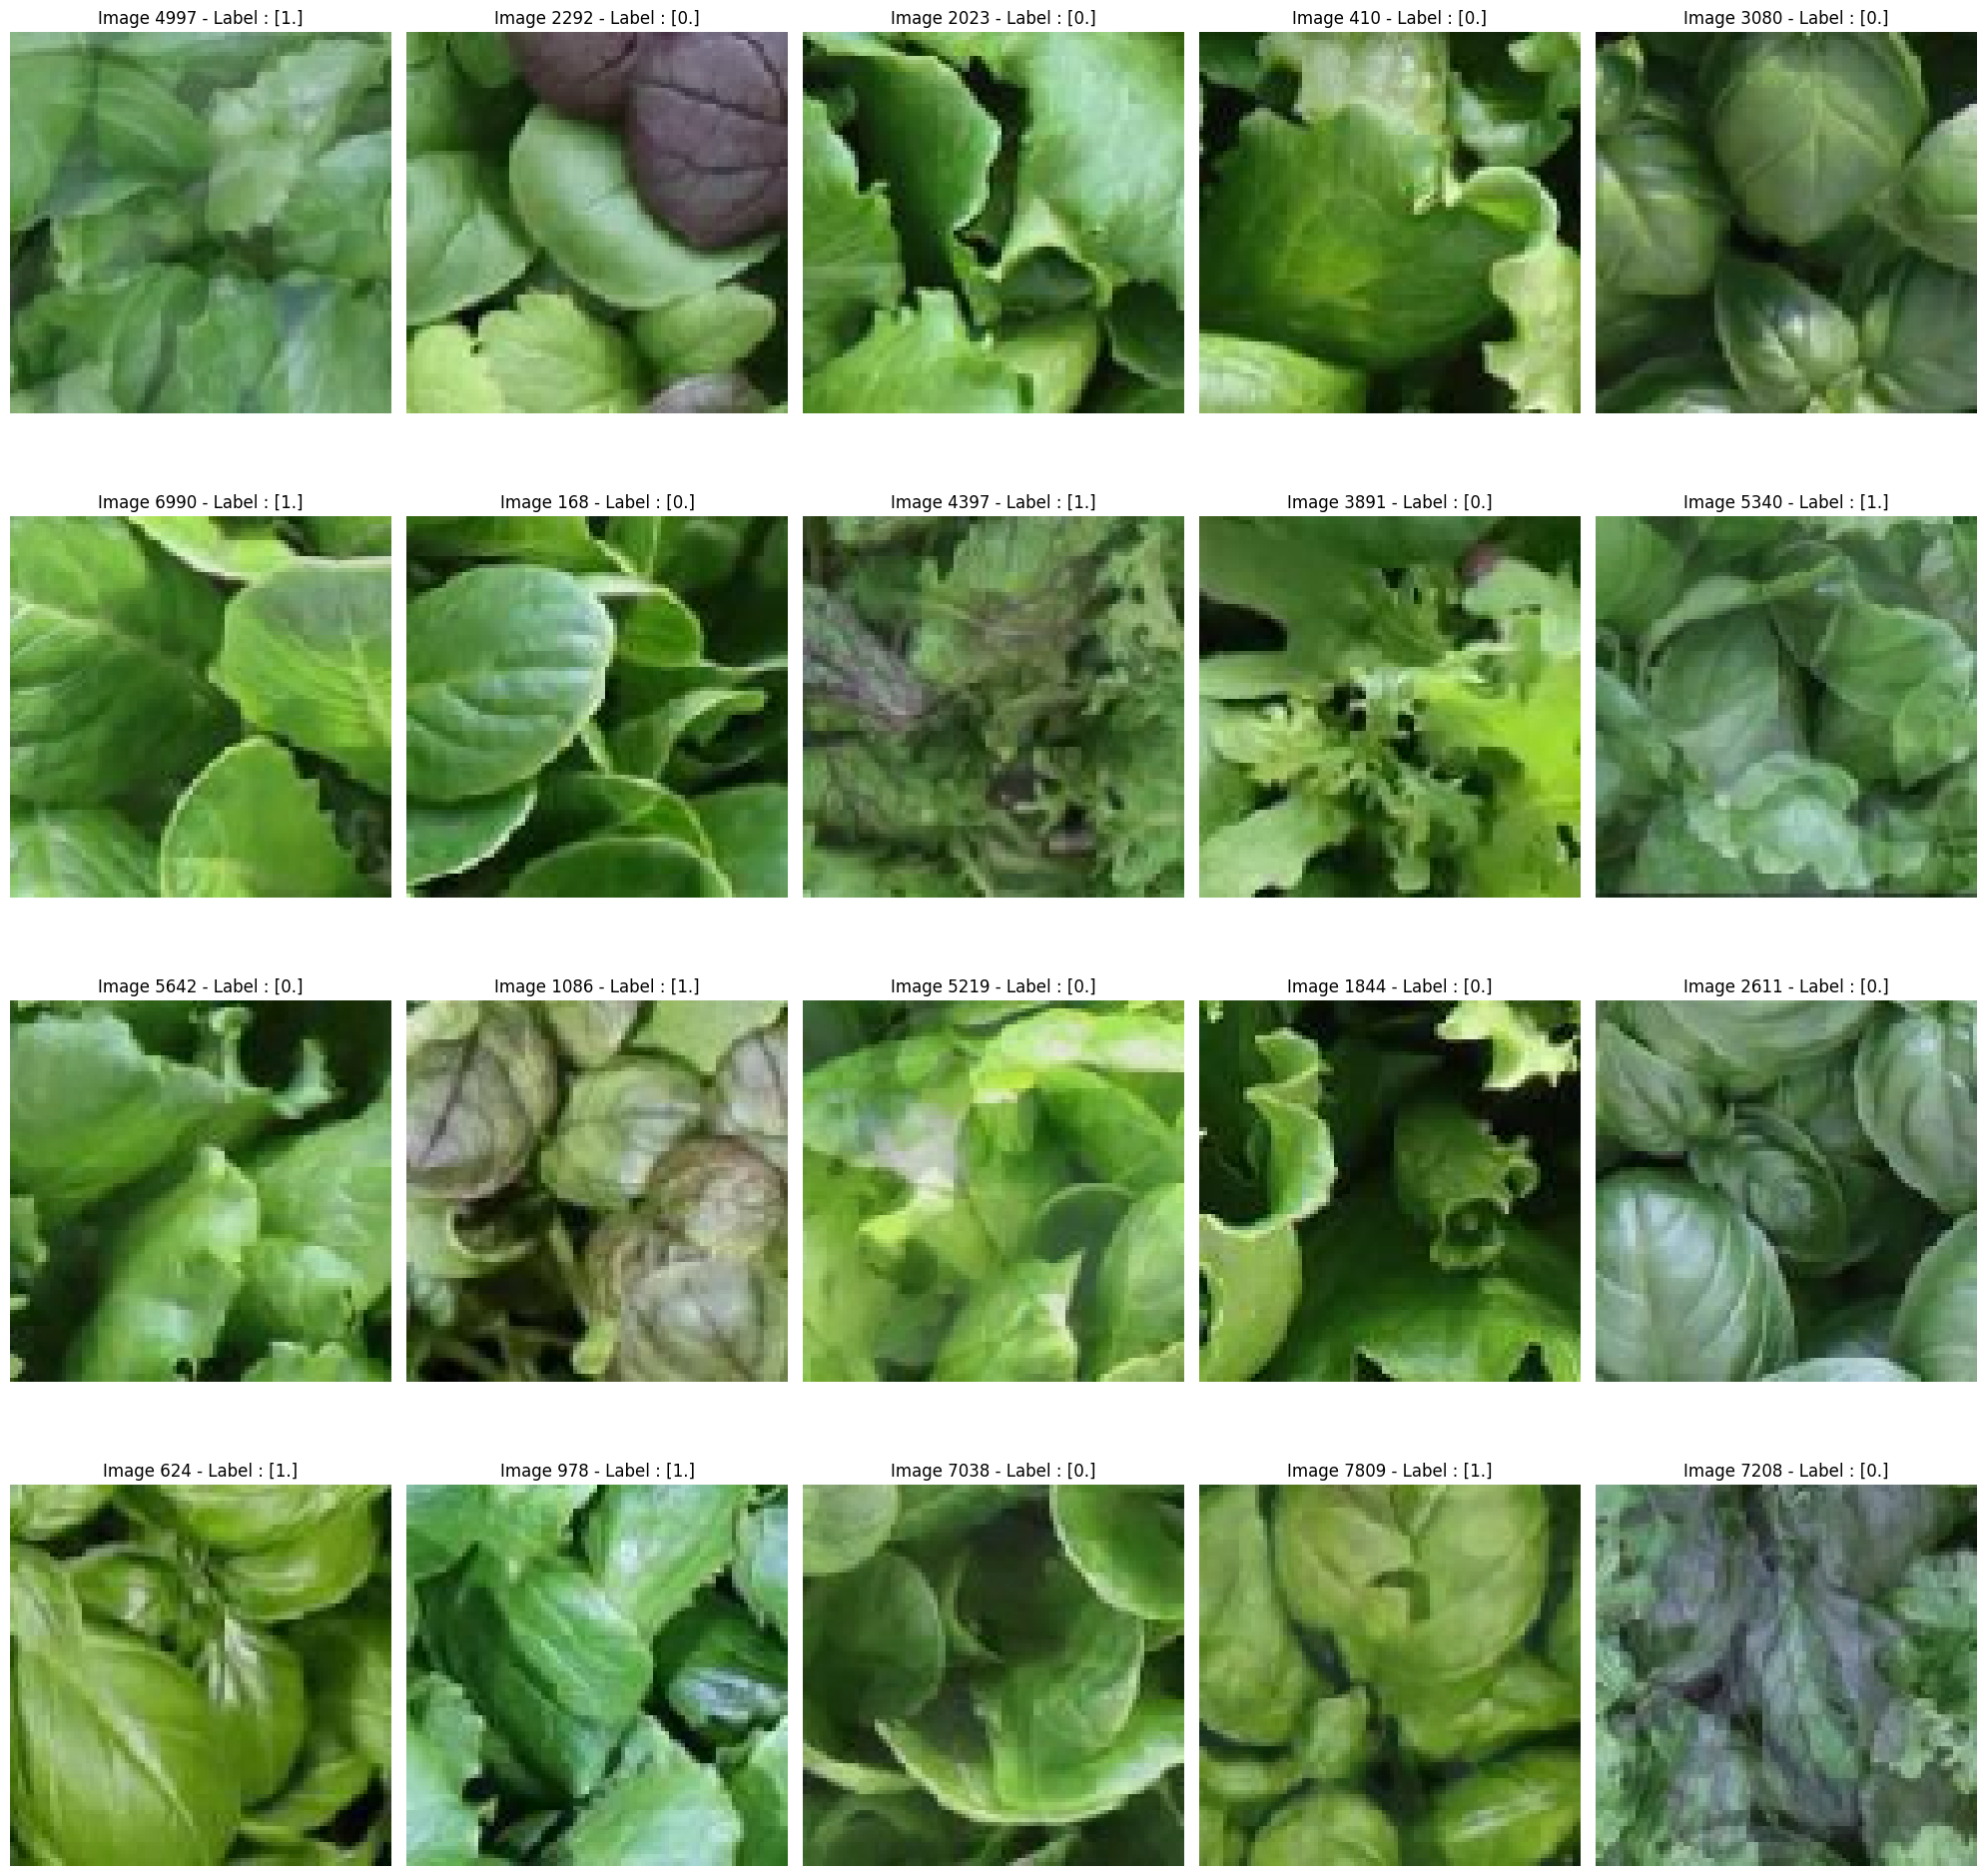

In [10]:
# Exploring training set
num_img = 20
random_offset = np.random.choice(y_train.shape[0], num_img, replace=False)
print(random_offset)

fig, axes = plt.subplots(4, num_img//4, figsize=(20, 20))
for i in range(num_img):
    ax = axes[i%4, i%num_img//4]
    ax.imshow(np.clip(X_train[random_offset[i]], 0, 255))  # Display clipped item images
    ax.set_title(f'Image {random_offset[i]} - Label : {y_train[random_offset[i]]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

[4997 6990 5642  624 2292  168 1086  978 2023 4397 5219 7038  410 3891
 1844 7809 3080 5340 2611 7208]


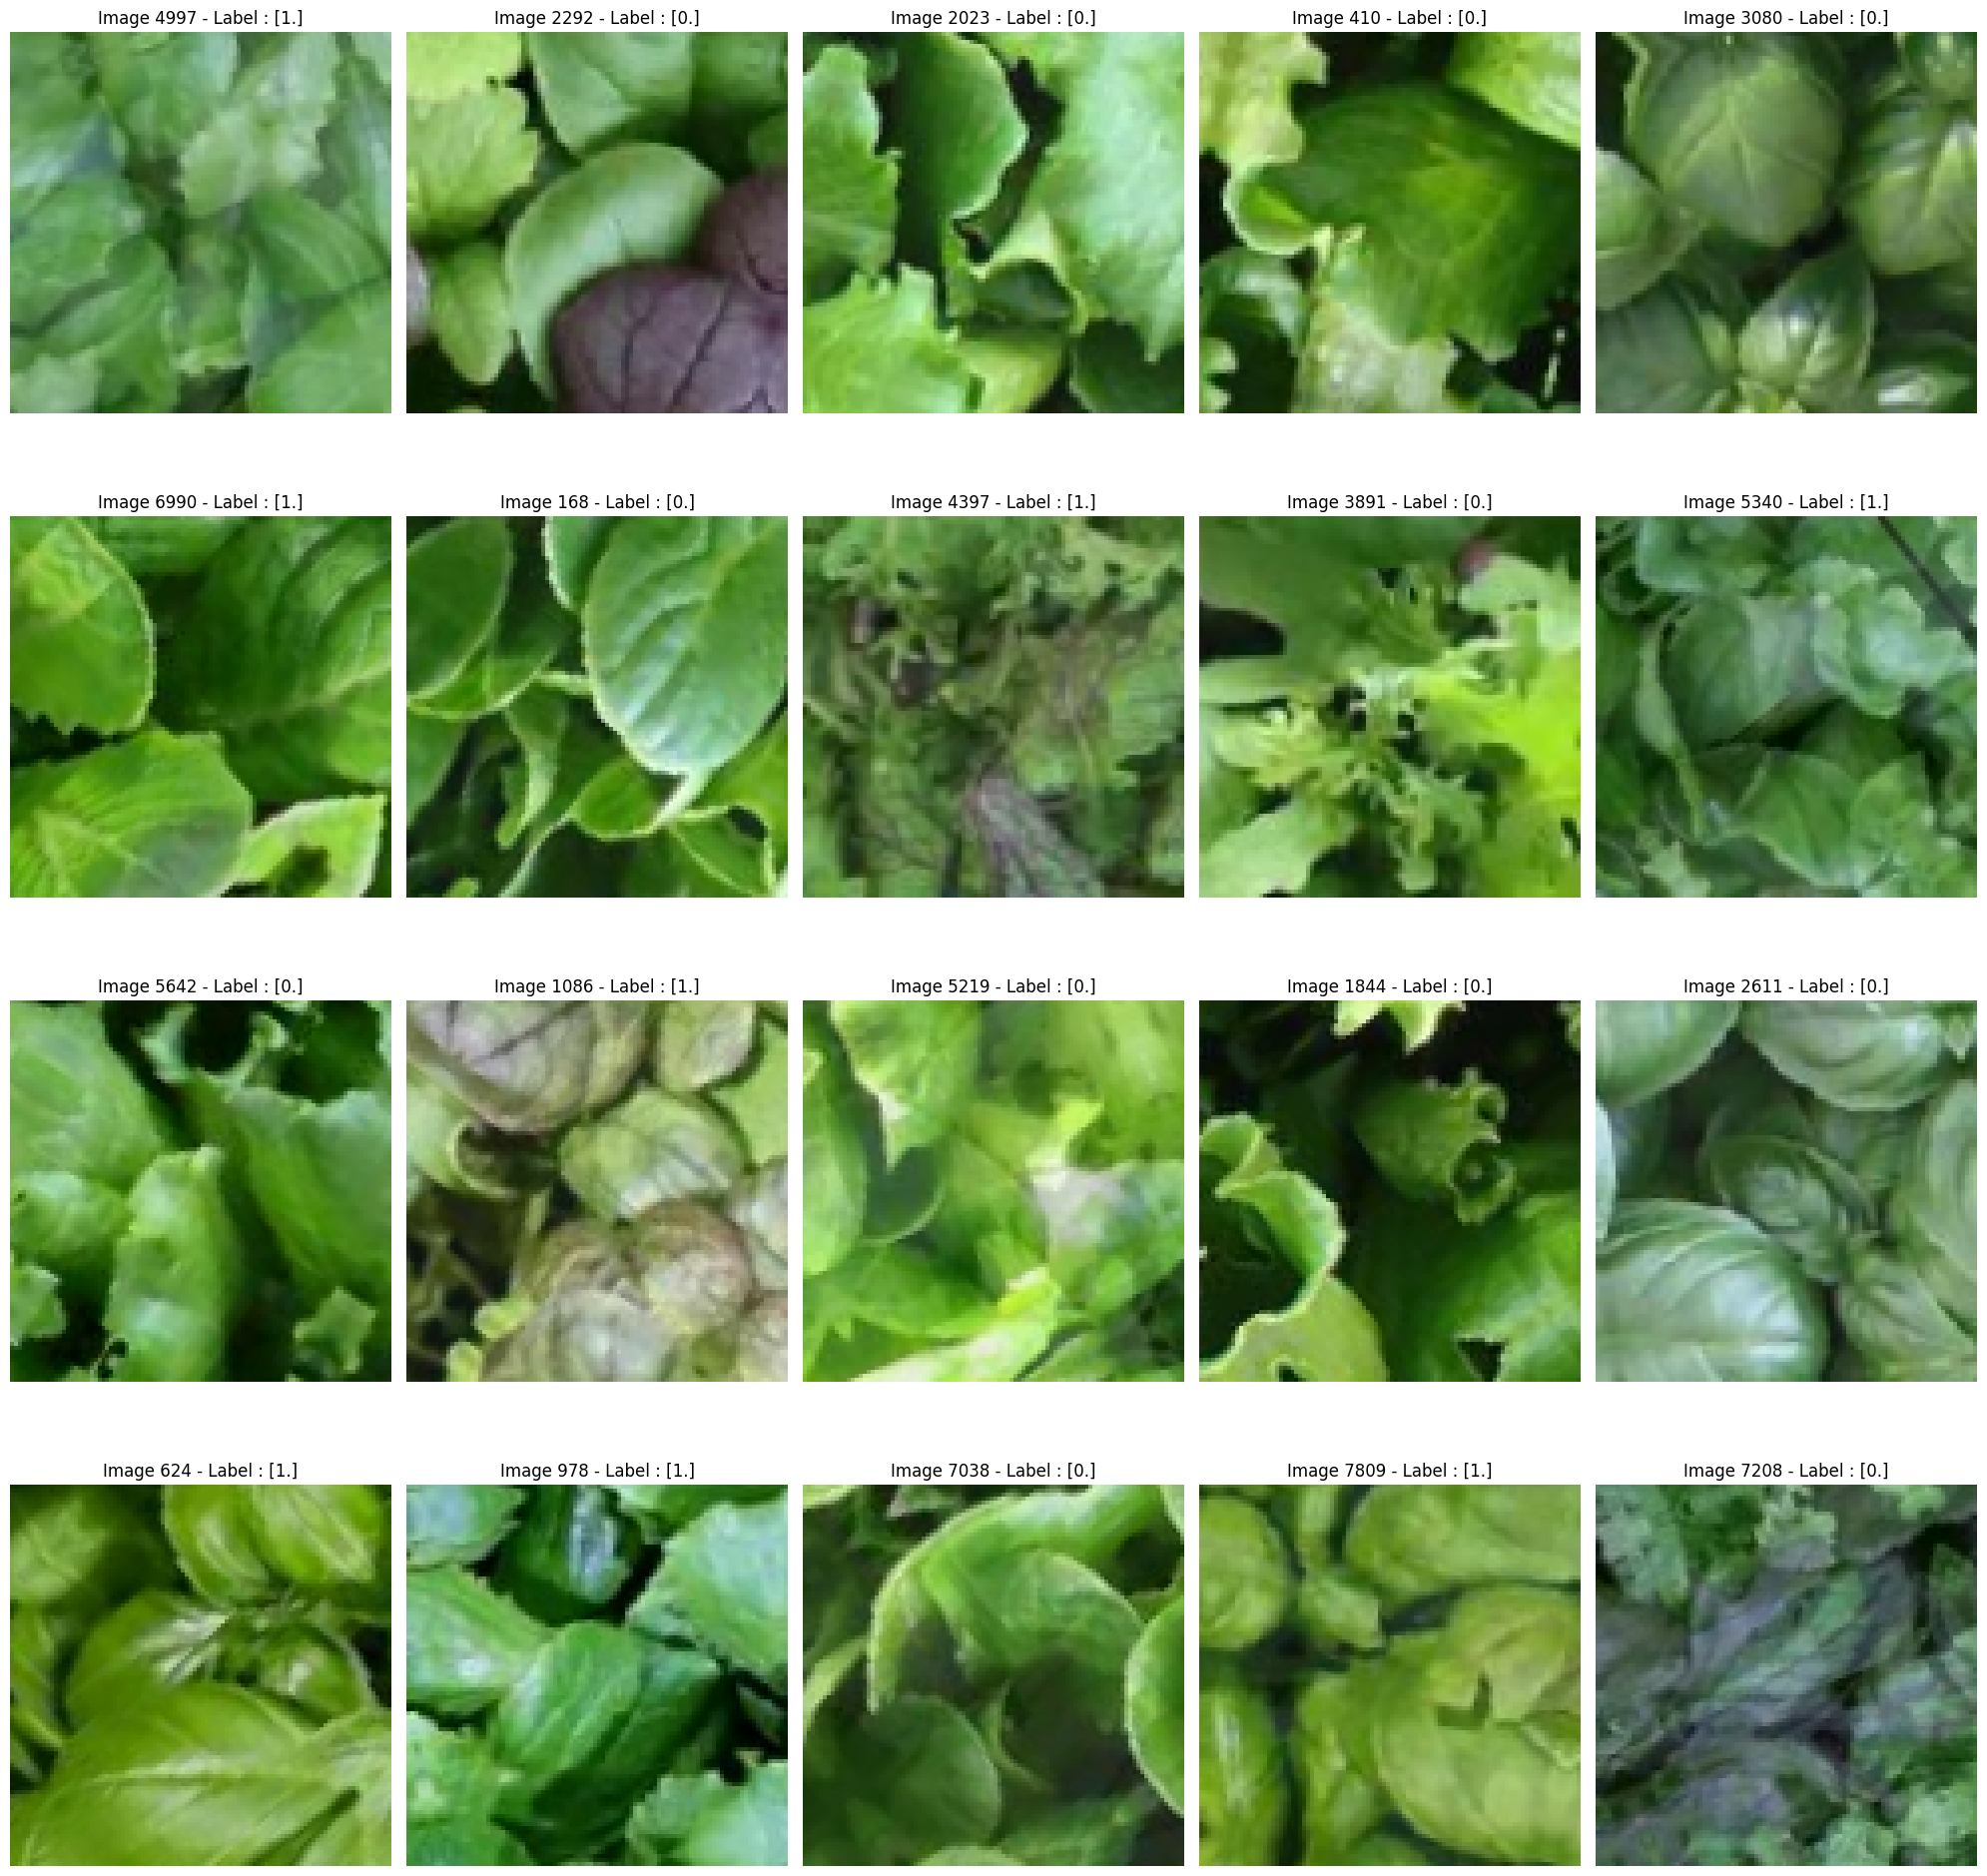

In [27]:
# Exploring preprocessed training data

preprocessing = tf.keras.Sequential([
      tfkl.RandomFlip(mode='horizontal_and_vertical'),
      tfkl.RandomRotation(360),
      tfkl.RandomContrast(0.05),
      #tfkl.RandomBrightness(0.08, value_range=(0, 1)),
      #tfkl.RandomBrightness(-0.08, value_range=(0, 1)),
      tfkl.RandomBrightness([0.08, -0.08], value_range=(0, 1)),
      tfkl.GaussianNoise(0.01),
      tfkl.Lambda(lambda x: tf.image.random_saturation(x, lower=0.8, upper=1.2)),
      #tfkl.RandomCrop(92,92),
      #tfkl.RandomZoom(0.02),
    ], name='preprocessing')


X_train_processed = preprocessing(X_train)

num_img = 20
print(random_offset) # smae images as previous cell

fig, axes = plt.subplots(4, num_img//4, figsize=(20, 20))
for i in range(num_img):
    ax = axes[i%4, i%num_img//4]
    ax.imshow(np.clip(X_train_processed[random_offset[i]], 0, 255))  # Display clipped item images
    ax.set_title(f'Image {random_offset[i]} - Label : {y_train[random_offset[i]]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

## Network

### HandMade

In [21]:
def HandMade(input_shape, output_shape, n_filters=16, lr=1e-3, ridge_param=1e-7, drop_rate=0.2, seed=seed):
    tf.random.set_seed(seed)

    preprocessing = tf.keras.Sequential([
      tfkl.RandomFlip(mode='horizontal_and_vertical'),
      tfkl.RandomRotation(360),
      tfkl.RandomContrast(0.05),
      tfkl.RandomBrightness([0.08, -0.08], value_range=(0, 1)),
      tfkl.GaussianNoise(0.01),
      tfkl.Lambda(lambda x: tf.image.random_saturation(x, lower=0.8, upper=1.20)),
      #tfkl.RandomCrop(92,92),
      #tfkl.RandomZoom(0.02),
    ], name='preprocessing')

    # Input

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    preprocessing_output = preprocessing(input_layer) # augmentation

    # Convolutional Layers

    x = tfkl.Conv2D(filters=n_filters, kernel_size=(3, 3),
                    kernel_initializer=tf.initializers.HeUniform(seed=seed),    # for relu
                    #kernel_initializer=tf.initializers.LecunNormal(seed=seed),  # for selu
                    padding='same', name='conv1')(preprocessing_output)
    x = tfkl.BatchNormalization(name='bn1')(x)
    #x = tfkl.Activation('selu', name='selu1')(x)
    x = tfkl.ReLU(name='relu1')(x)
    x = tfkl.Dropout(drop_rate)(x)
    x = tfkl.MaxPooling2D(pool_size=(2, 2), name='mp1')(x)
    #x = tfkl.AvgPool2D(pool_size=(2, 2), name='avg1')(x)

    x = tfkl.Conv2D(filters=n_filters*2, kernel_size=(3, 3),
                    kernel_initializer=tf.initializers.HeUniform(seed=seed),    # for relu
                    #kernel_initializer=tf.initializers.LecunNormal(seed=seed),  # for selu
                    padding='same', name='conv2')(x)
    x = tfkl.BatchNormalization(name='bn2')(x)
    #x = tfkl.Activation('selu', name='selu2')(x)
    x = tfkl.ReLU(name='relu2')(x)
    x = tfkl.Dropout(drop_rate)(x)
    x = tfkl.MaxPooling2D(pool_size=(2, 2), name='mp2')(x)
    #x = tfkl.AvgPool2D(pool_size=(2, 2), name='avg2')(x)

    x = tfkl.Conv2D(filters=n_filters*4, kernel_size=(3, 3),
                    kernel_initializer=tf.initializers.HeUniform(seed=seed),    # for relu
                    #kernel_initializer=tf.initializers.LecunNormal(seed=seed),  # for selu
                    padding='same', name='conv3')(x)
    x = tfkl.BatchNormalization(name='bn3')(x)
    #x = tfkl.Activation('selu', name='selu3')(x)
    x = tfkl.ReLU(name='relu3')(x)
    x = tfkl.Dropout(drop_rate)(x)
    x = tfkl.MaxPooling2D(pool_size=(2, 2), name='mp3')(x)
    #x = tfkl.AvgPool2D(pool_size=(2, 2), name='avg3')(x)

    x = tfkl.Conv2D(filters=n_filters*8, kernel_size=(3, 3),
                    kernel_initializer=tf.initializers.HeUniform(seed=seed),    # for relu
                    #kernel_initializer=tf.initializers.LecunNormal(seed=seed),  # for selu
                    padding='same', name='conv4')(x)
    x = tfkl.BatchNormalization(name='bn4')(x)
    #x = tfkl.Activation('selu', name='selu4')(x)
    x = tfkl.ReLU(name='relu4')(x)
    x = tfkl.Dropout(drop_rate)(x)
    x = tfkl.MaxPooling2D(pool_size=(2, 2), name='mp4')(x)
    #x = tfkl.AvgPool2D(pool_size=(2, 2), name='avg4')(x)

    x = tfkl.Conv2D(filters=n_filters*16, kernel_size=(3, 3),
                    kernel_initializer=tf.initializers.HeUniform(seed=seed),    # for relu
                    #kernel_initializer=tf.initializers.LecunNormal(seed=seed),  # for selu
                    padding='same', name='conv5')(x)
    x = tfkl.BatchNormalization(name='bn5')(x)
    #x = tfkl.Activation('selu', name='selu5')(x)
    x = tfkl.ReLU(name='relu5')(x)
    x = tfkl.Dropout(drop_rate)(x)
    x = tfkl.MaxPooling2D(pool_size=(2, 2), name='mp5')(x)
    #x = tfkl.AvgPool2D(pool_size=(2, 2), name='avg5')(x)

    # Global Average Pooling

    x = tfkl.GlobalAveragePooling2D(name='GAP')(x)

    # Output

    output_layer = tfkl.Dense(units=output_shape,
                              activation='sigmoid',
                              kernel_initializer=tf.initializers.GlorotUniform(seed=seed), # for sigmoid
                              name='Output')(x)

    # Model creation

    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='HandMade')

    model.compile(
        loss=tfk.losses.BinaryCrossentropy(),
        optimizer = tfk.optimizers.AdamW(learning_rate=lr, weight_decay=ridge_param),  # weight_decay to tune (RIDGE)
        metrics=['accuracy']
    )

    return model

### Implementation

Model: "HandMade"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 conv1 (Conv2D)              (None, 96, 96, 16)        448       
                                                                 
 bn1 (BatchNormalization)    (None, 96, 96, 16)        64        
                                                                 
 relu1 (ReLU)                (None, 96, 96, 16)        0         
                                                                 
 dropout_10 (Dropout)        (None, 96, 96, 16)        0         
                                                                 
 avg1 (AveragePooling2D)     (None, 48, 48, 16)        0  

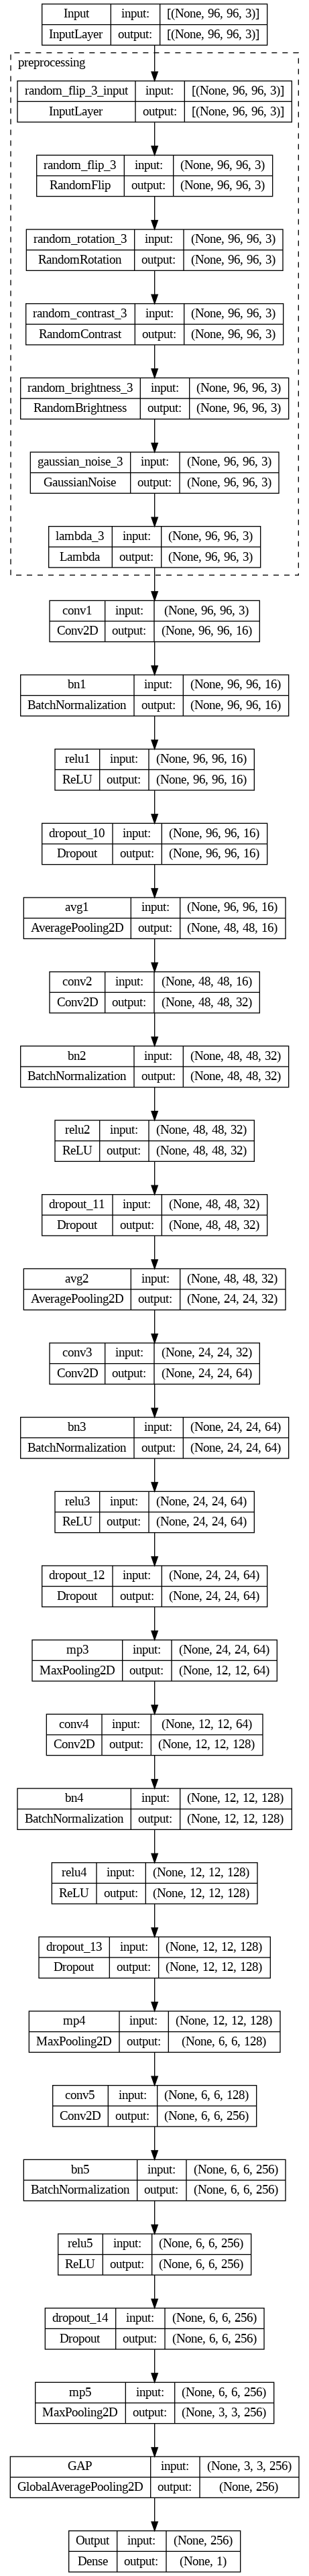

In [20]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1]

model = HandMade(input_shape, output_shape, n_filters=16, lr=1e-4, ridge_param=1e-6, drop_rate=0.02)
model.summary()
tfk.utils.plot_model(model, show_shapes=True, expand_nested=True)

In [14]:
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=256, # 32, 64, 128, 256 try different values
    epochs=250, # use 50 for beanchmarking
    validation_data=(X_val, y_val),
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, mode='max', restore_best_weights=True),
               tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=15, min_lr=1e-6, mode='max'),
               ]
).history

Epoch 1/250
35/35 [==============================] - 13s 156ms/step - loss: 0.6348 - accuracy: 0.6507 - val_loss: 0.6421 - val_accuracy: 0.6227 - lr: 1.0000e-04
Epoch 2/250
35/35 [==============================] - 4s 123ms/step - loss: 0.6095 - accuracy: 0.6735 - val_loss: 0.7604 - val_accuracy: 0.6309 - lr: 1.0000e-04
Epoch 3/250
35/35 [==============================] - 4s 118ms/step - loss: 0.6013 - accuracy: 0.6797 - val_loss: 0.9361 - val_accuracy: 0.6309 - lr: 1.0000e-04
Epoch 4/250
35/35 [==============================] - 4s 116ms/step - loss: 0.5943 - accuracy: 0.6848 - val_loss: 0.9757 - val_accuracy: 0.6309 - lr: 1.0000e-04
Epoch 5/250
35/35 [==============================] - 4s 123ms/step - loss: 0.5863 - accuracy: 0.6922 - val_loss: 0.8734 - val_accuracy: 0.6309 - lr: 1.0000e-04
Epoch 6/250
35/35 [==============================] - 4s 119ms/step - loss: 0.5790 - accuracy: 0.6994 - val_loss: 0.9009 - val_accuracy: 0.6309 - lr: 1.0000e-04
Epoch 7/250
35/35 [====================

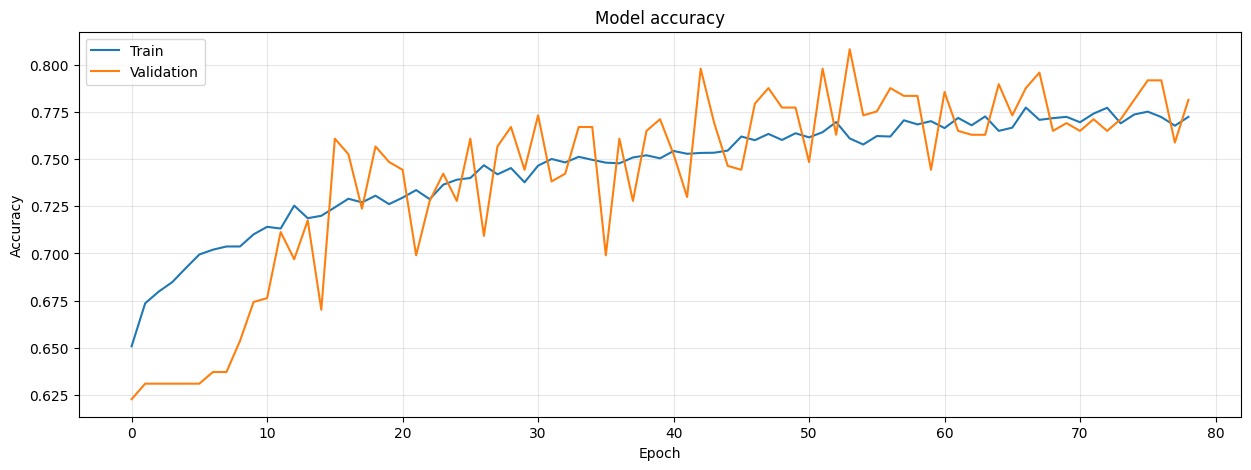

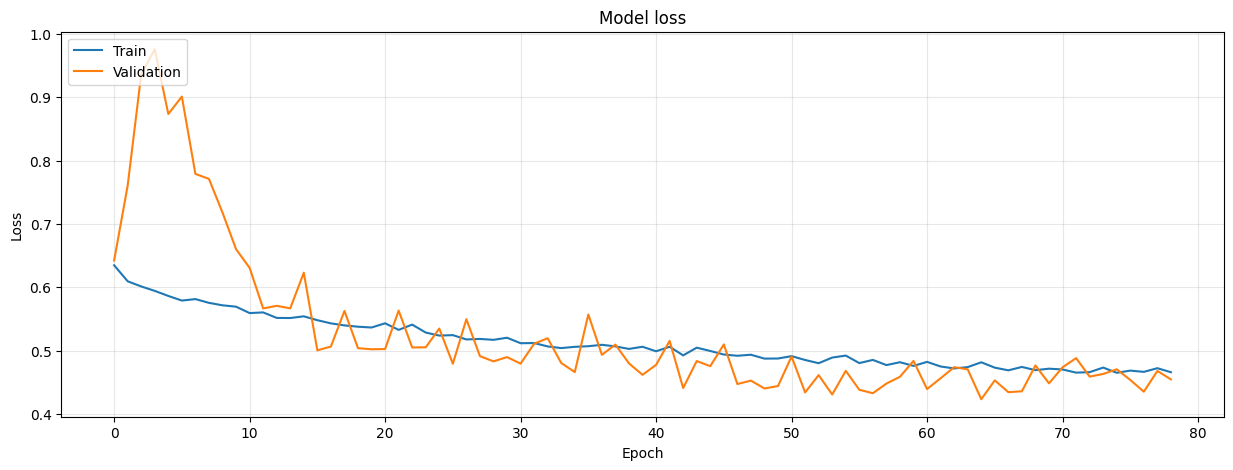

In [15]:
# Plot training & validation accuracy values
plt.figure(figsize=(15,5))
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.grid(alpha=.3)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(15,5))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.grid(alpha=.3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [16]:
model.save('model_name')

In [17]:
del model